In [84]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/Colab Notebooks/ECE_Project')

In [0]:
import CNN_Lib
import CNN_BuildingBlock_Lib as BB
import RNN_BuildingBlock_Lib as RNN_BB
import CombinationModel as ComboCNN
import CombinationModel_RNN_CNN as RNN_CNN
import CombinationModel_LSTM_FCN as LSTM_FCN
import numpy as np 
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import random
import pdb
import copy
import matplotlib.pyplot as plt

In [87]:
dir = '/content/gdrive/My Drive/Colab Notebooks/ECE_Project'
X_test = np.load(dir + '/X_test.npy')
y_test = np.load(dir + '/y_test.npy')
person_train_valid = np.load(dir + '/person_train_valid.npy')
X_train_valid = np.load(dir + '/X_train_valid.npy')
y_train_valid = np.load(dir + '/y_train_valid.npy')
person_test = np.load(dir + '/person_test.npy')
print ('Training/Valid data shape: {}' .format(X_train_valid.shape))
print ('Test data shape: {}' .format(X_test.shape))
print ('Training/Valid target shape: {}' .format(y_train_valid.shape))
print ('Test target shape: {}' .format(y_test.shape))
print ('Person train/valid shape: {}' .format(person_train_valid.shape))
print ('Person test shape: {}' .format(person_test.shape))


Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [0]:
#transform data into torch-readable data types
#2115 number of trials from 9 people
#four possible classes of outputs

Xtrain = torch.from_numpy(X_train_valid)
Ytrain = torch.from_numpy(y_train_valid)
Xtest = torch.from_numpy(X_test)
Ytest = torch.from_numpy(y_test)

In [0]:
def map_to_class(input_labels):
  mask1 = (input_labels == 769)*0
  mask2 = (input_labels == 770)*1
  mask3 = (input_labels == 771)*2
  mask4 = (input_labels == 772)*3

  return (mask1 + mask2 + mask3 + mask4)

In [0]:
#perhaps normalizing noisy data will help learning?
#tried first with L2, improved slightly...
def normalize(x):
  return F.normalize(x, p=1, dim=2)
#  return x / x.max(0, keepdim=True)[0]

In [0]:
def plot_val_train(validation_acc, train_acc, k, its):
  f = plt.figure(figsize=(15, 10))
  if mode == "All":
    plt.title(f"Model Performance while Validating on K-Fold {k}")
  elif mode == "One":
    plt.title(f"Model Performance While Training on One Person {k}")

  plt.plot(validation_acc, 'g-', label='validation')
  plt.plot(train_acc, 'b-', label='training')
  plt.xticks(np.arange(0, its, step=200))  # Set label locations.
  plt.xlabel("Iterations")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  return f


In [0]:
def smooth(x,window_size=11,window='hanning'):
  """
    Adapted from SciPy Cookbook
    Window can be: ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
  """
  smoothed = np.r_[x[window_size-1:0:-1], x, x[-2:-window_size-1:-1]]
  
  #moving average
  if window == 'flat':
      w = np.ones(window_len,'d')
  else:
      w = eval('np.' + window + '(window_size)')

  smoothed = np.convolve(w/w.sum(), smoothed, mode='valid')
  if len(x) < len(smoothed):
    dif = abs(len(x) - len(smoothed))//2
    smoothed = smoothed[dif:len(smoothed)-dif]
  return smoothed

In [0]:
def augment_data(data_set, window_size, window):
  out = np.zeros_like(data_set)
  out = torch.from_numpy(out)
  for i in range(data_set.shape[0]):
    for j in range(data_set.shape[1]):
      out[i,j,:] = torch.from_numpy(smooth(data_set[i,j,:], window_size, window))
  return out

In [94]:
######### AUGMENT DATASET
Smoothed = augment_data(X_train_valid, 11,'hanning')
Normalized = normalize(Xtrain)

idx1 = np.arange(X_train_valid.shape[0]//2)
np.random.shuffle(idx1)

idx2 = np.arange(X_train_valid.shape[0]//2)
np.random.shuffle(idx2)

OutX = torch.cat((Xtrain, Smoothed[idx1], Normalized[idx2]),0)
OutY = torch.cat((Ytrain, Ytrain[idx1], Ytrain[idx2]),0)
print(OutX.size())

Xtrain = OutX
Ytrain = OutY

torch.Size([4229, 22, 1000])


In [95]:
########## INITIALIZE LSTM-FCN COMBINATION MODEL ########## 

Trials, InputDim, SeqDim = X_train_valid.shape
num_features = InputDim
Tests = y_test.shape

batch_size = 30

#-----LSTM tweak here----#
hidden_dim = 64 #above 150 and we get low training accuracy, 62 does way better than 128
num_layers = 1 #increasing this makes training take MUCH longer, lower validation and lower training accuracy
dropout = 0.35

#----NORM DATA tweak here---#
norm = True

#-----OPTIM tweak here----#
learning_rate = 0.001 #0 we trained faster with this vs 0.0001 
L2 = 0.0002

LSTM1 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)
LSTM2 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)
LSTM3 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)
LSTM4 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)
LSTM5 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)

LSTM1.to('cuda:0') #--- activate the GPU
LSTM2.to('cuda:0')
LSTM3.to('cuda:0')
LSTM4.to('cuda:0')
LSTM5.to('cuda:0')

EEG_LSTM_BuildingBlock(
  (LSTM): LSTM(22, 64)
  (Dropout): Dropout(p=0.35, inplace=False)
  (FC): Linear(in_features=12800, out_features=4, bias=True)
)

In [0]:
########## CHOOSE LOSS  ###########
loss1 = torch.nn.CrossEntropyLoss()
loss2 = torch.nn.CrossEntropyLoss()
loss3 = torch.nn.CrossEntropyLoss()
loss4 = torch.nn.CrossEntropyLoss()
loss5 = torch.nn.CrossEntropyLoss()

######### CHOOSE OPTIMIZER ########
optim1 = torch.optim.Adam(LSTM1.parameters(), lr=learning_rate, weight_decay=L2)
optim2 = torch.optim.Adam(LSTM2.parameters(), lr=learning_rate, weight_decay=L2)
optim3 = torch.optim.Adam(LSTM3.parameters(), lr=learning_rate, weight_decay=L2)
optim4 = torch.optim.Adam(LSTM4.parameters(), lr=learning_rate, weight_decay=L2)
optim5 = torch.optim.Adam(LSTM5.parameters(), lr=learning_rate, weight_decay=L2)
#optim = torch.optim.Adadelta(combo_model.parameters()) << does worse than Adam, we overfit so much 

Here, I've split the data into 5 chunks. I'll train each LSTM classifier independently, then take the 'mode' of the collective predictions to deliver the final classification, which will then be compared against the expected classes for a final validation accuracy.

...... Training for Epoch 0 ......
______ Training for k-folds [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


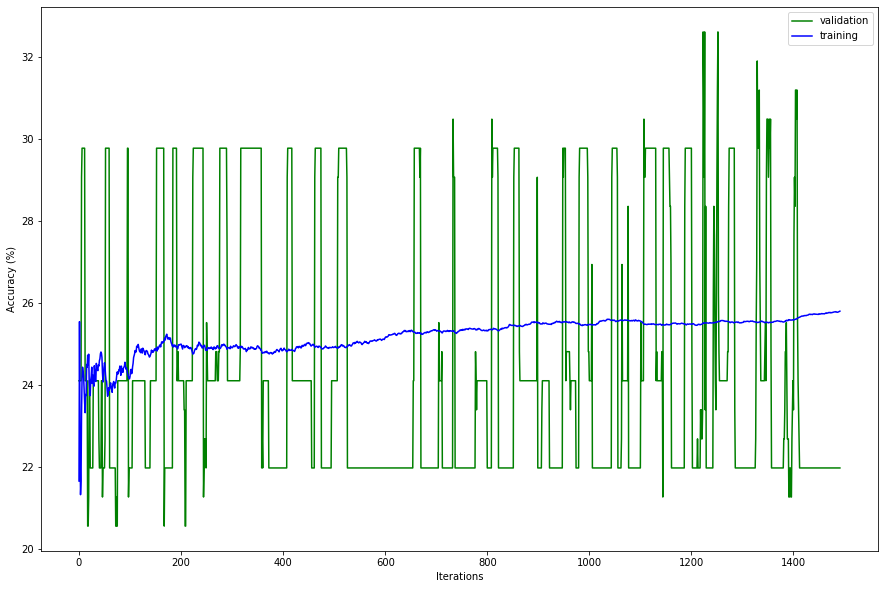

______ Training for k-folds [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14] ______


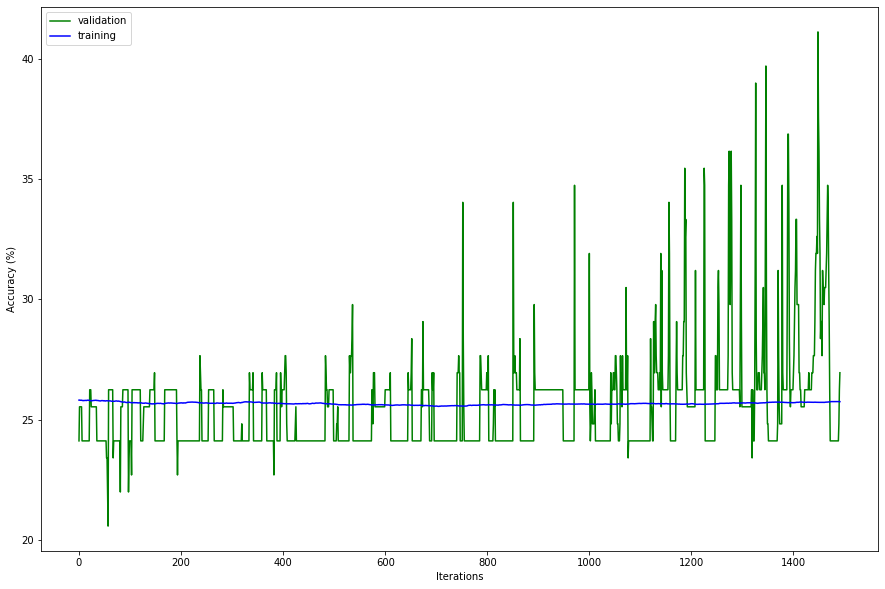

______ Training for k-folds [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14] ______


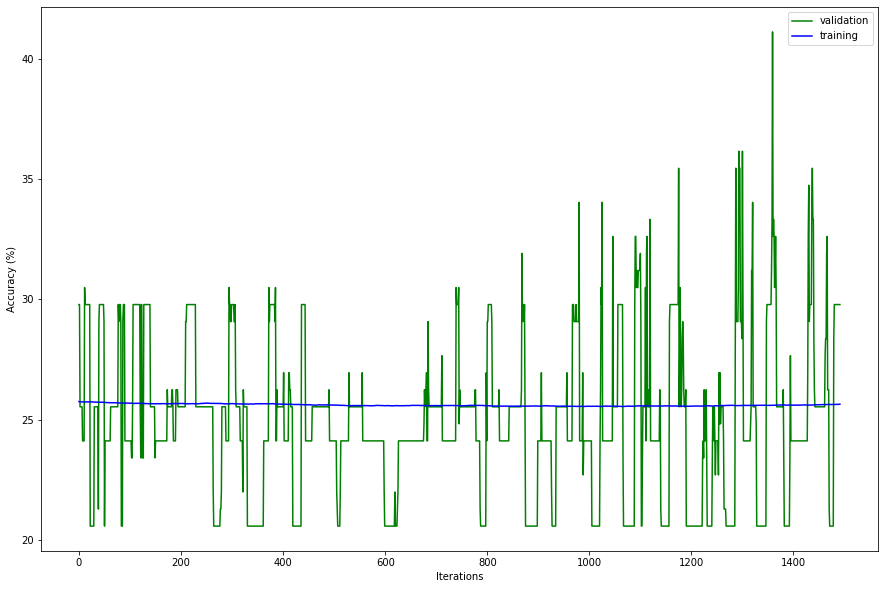

______ Training for k-folds [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14] ______


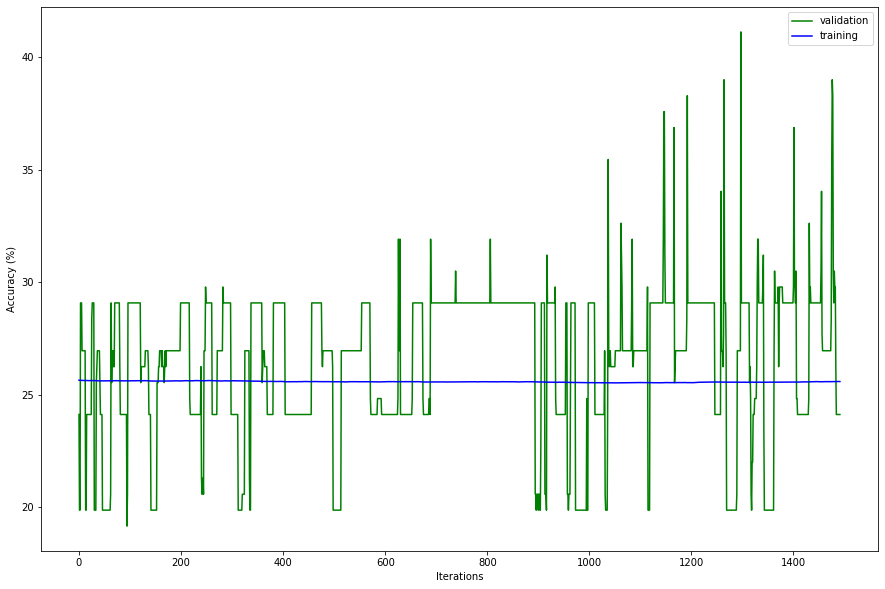

______ Training for k-folds [ 0  1  2  3  5  6  7  8  9 10 11 12 13 14] ______


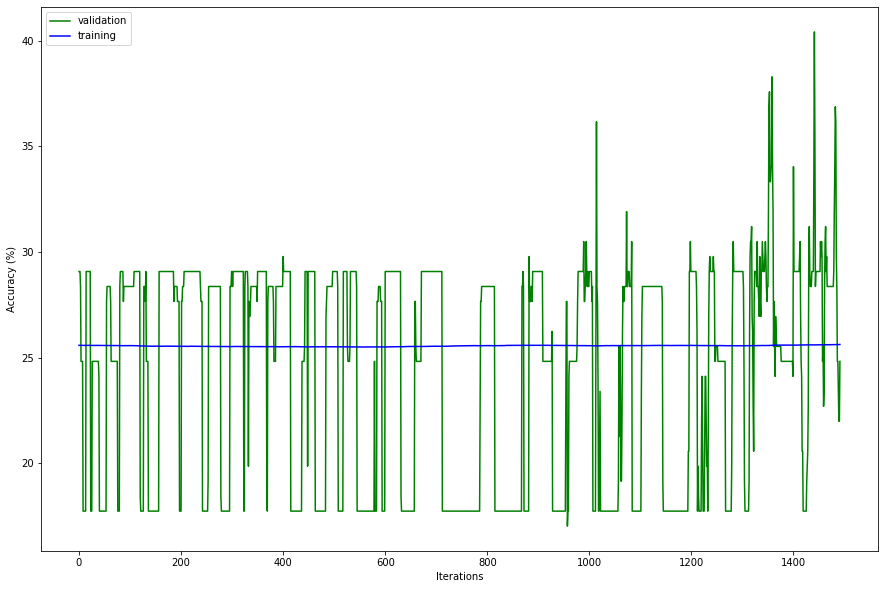

______ Training for k-folds [ 0  1  2  3  4  6  7  8  9 10 11 12 13 14] ______


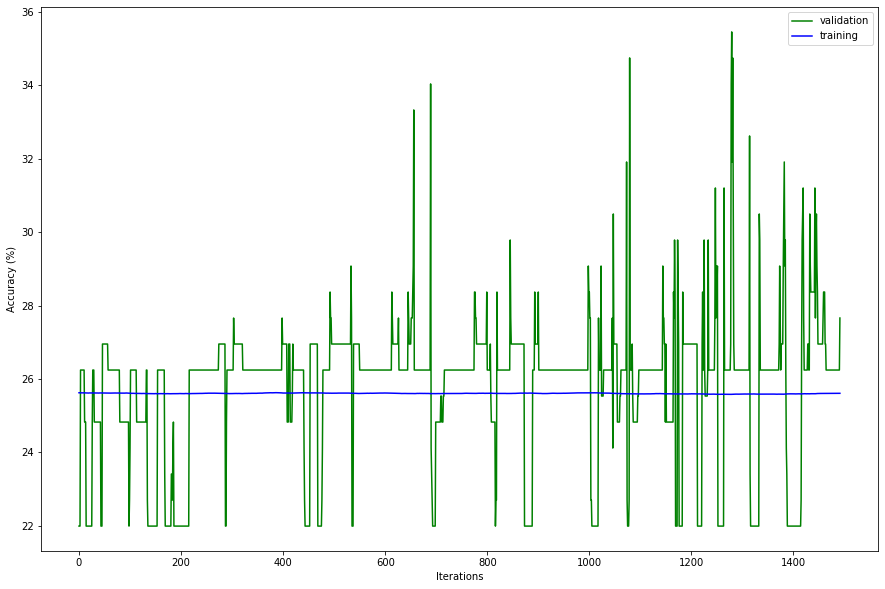

______ Training for k-folds [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14] ______


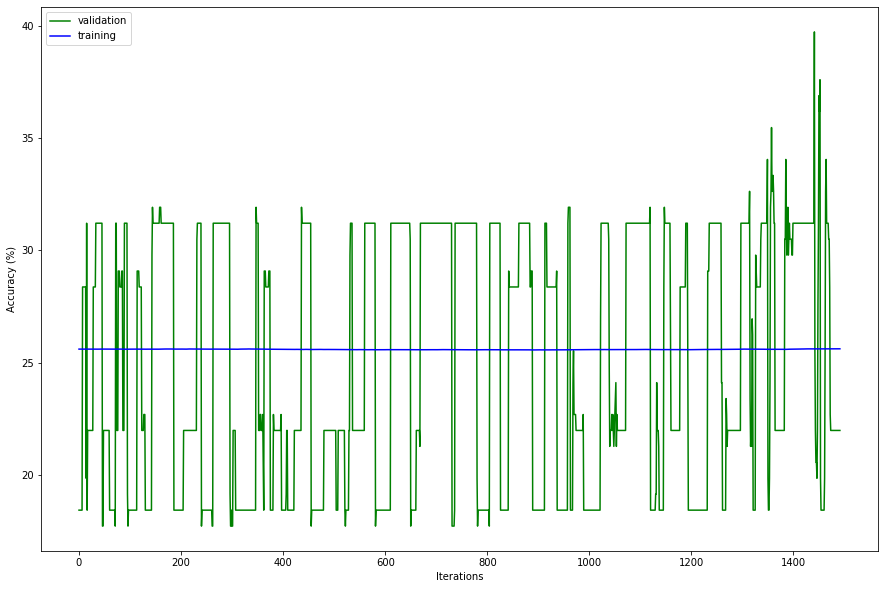

______ Training for k-folds [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14] ______


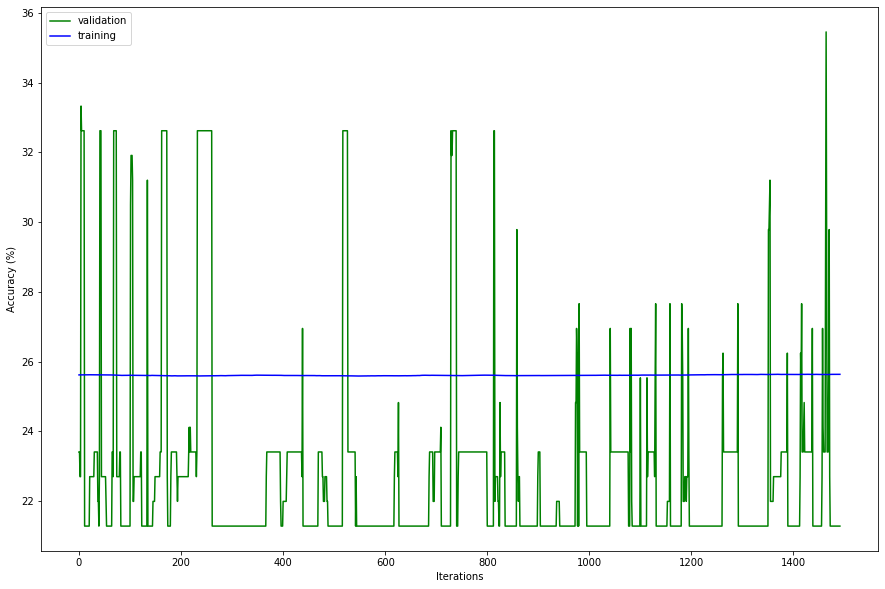

______ Training for k-folds [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14] ______


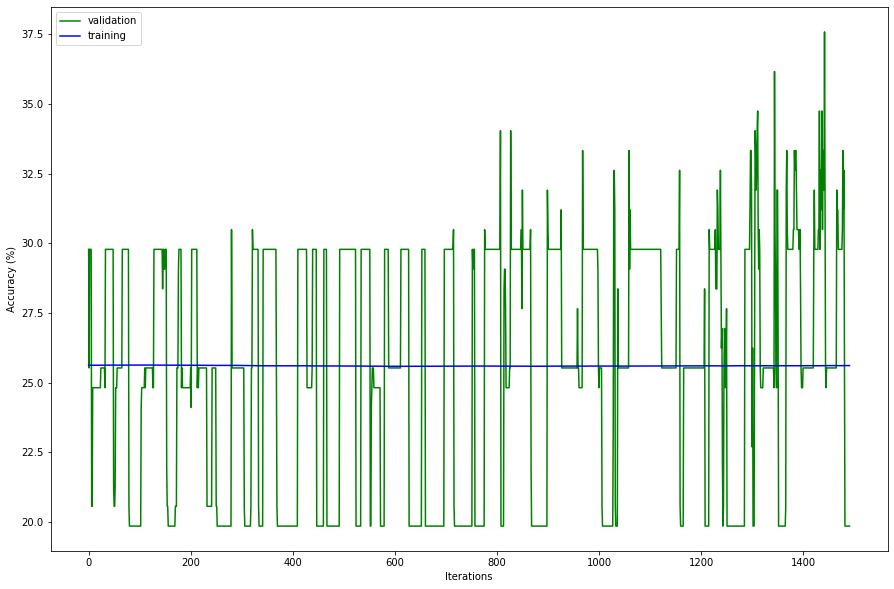

______ Training for k-folds [ 0  1  2  3  4  5  6  7  8 10 11 12 13 14] ______


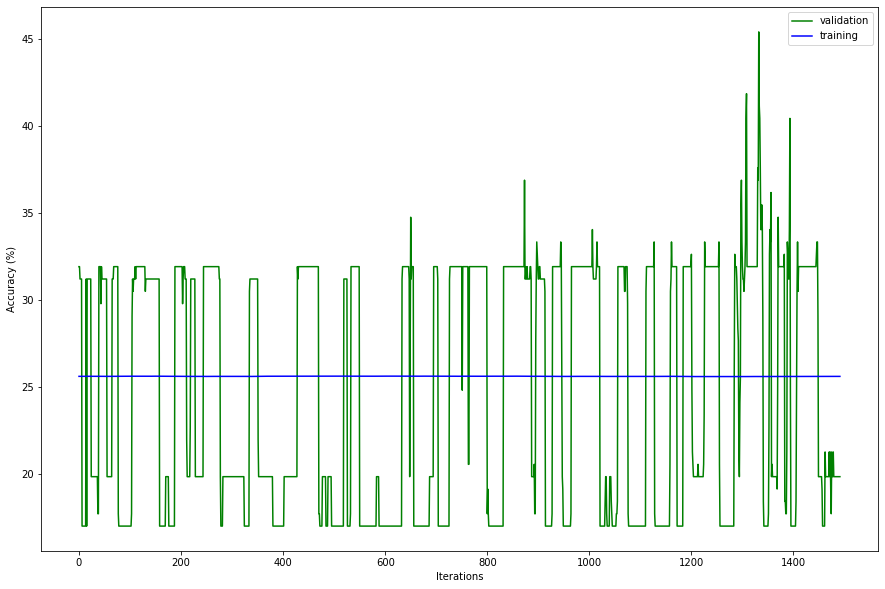

______ Training for k-folds [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14] ______


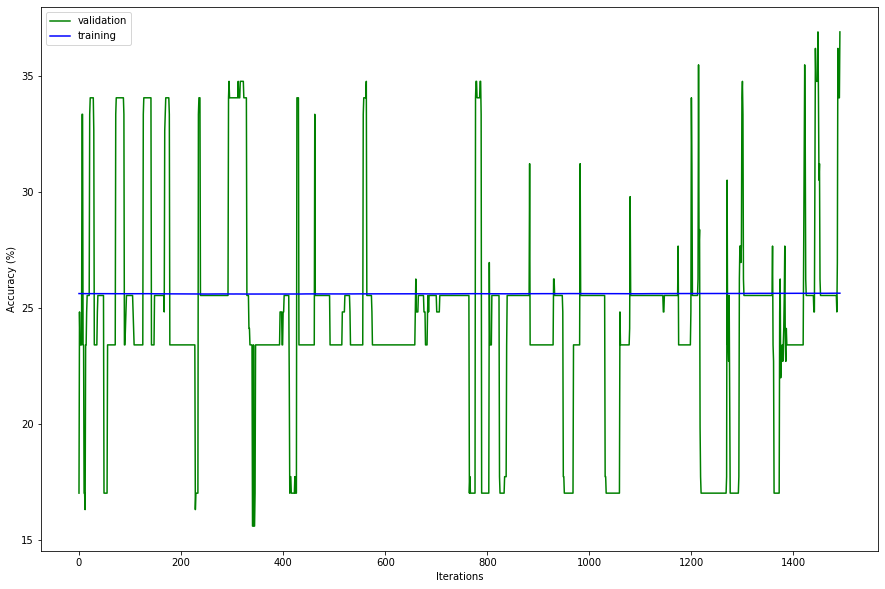

______ Training for k-folds [ 0  1  2  3  4  5  6  7  8  9 10 12 13 14] ______


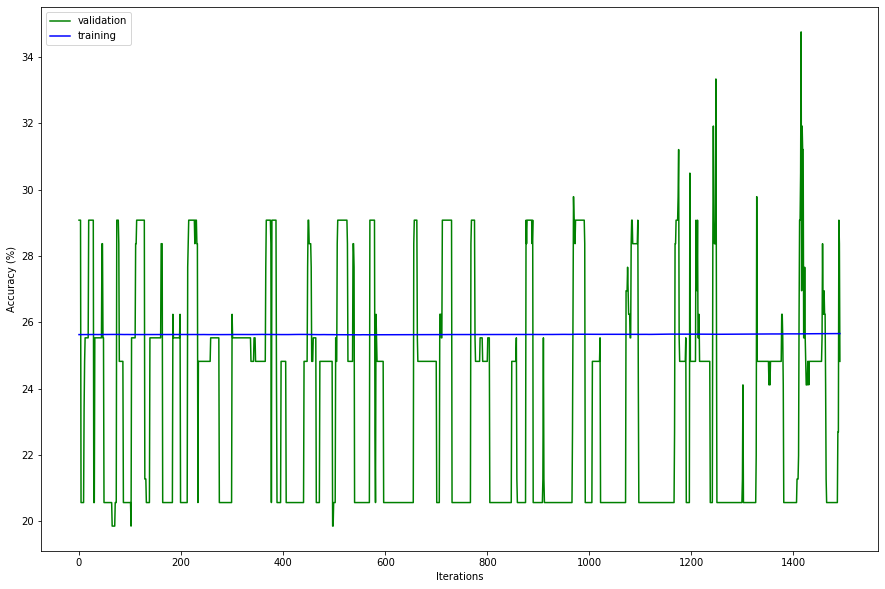

______ Training for k-folds [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14] ______


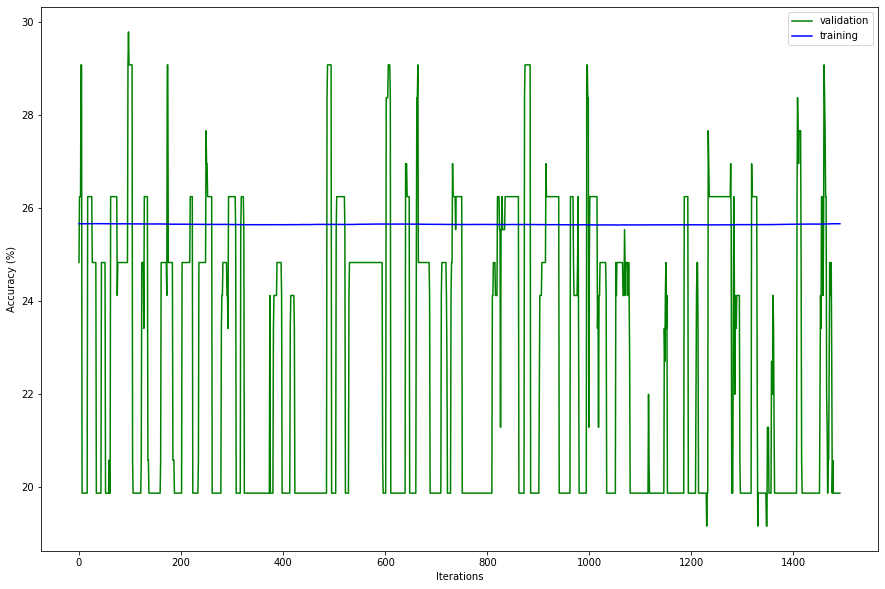

______ Training for k-folds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14] ______


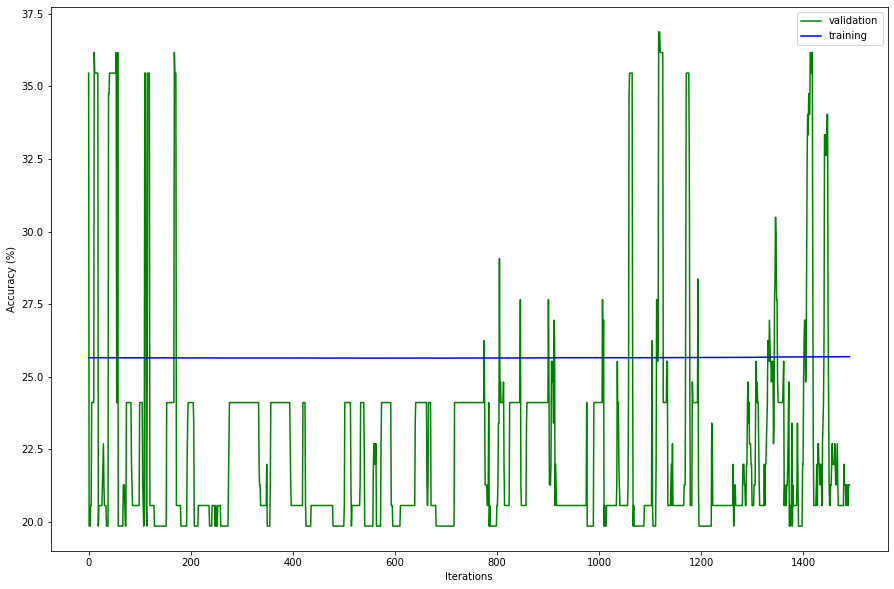

______ Training for k-folds [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] ______


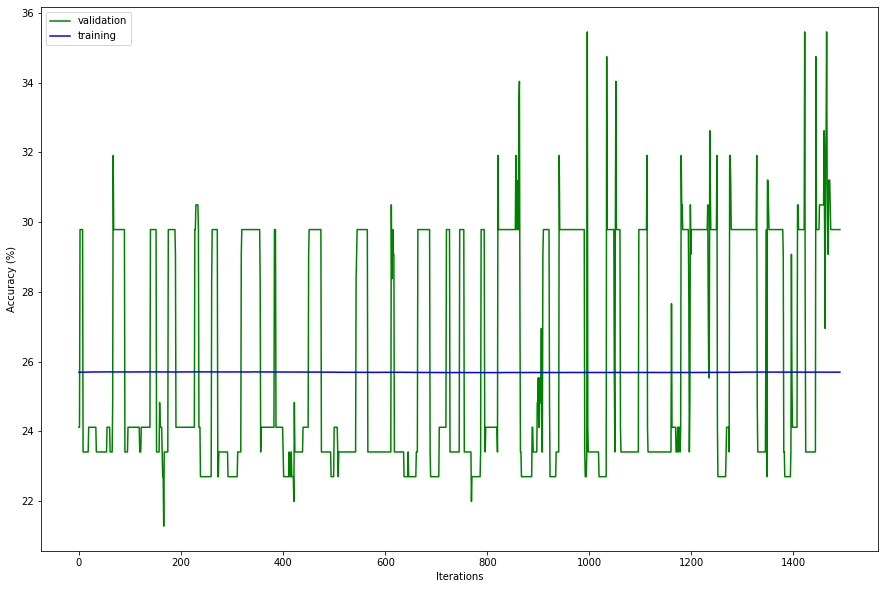

In [97]:
######## TRAIN IT ########
#------ With Early Stopping AND K-Fold Validation -----#
epochs = 1
kfolds = 15
iterations = 1500
iter_ = 0
validate_fold = 0
SEED = 2000

stop_now = False
loss_store = [[] for i in range(kfolds)]
validation_store = [[] for i in range(kfolds)]
training_store = [[] for i in range(kfolds)]
network_store = [[] for i in range(kfolds)]
model_store = []
model_store_info = []

#normalize here
if norm:
  Xtrain = normalize(Xtrain)

#k fold validation here
np.random.seed(random.randint(1,SEED))
fold_size = int(Trials/kfolds)
idx = np.arange(Trials)
np.random.shuffle(idx)
Xtrain_Shuffled = Xtrain[idx]
Ytrain_Shuffled = Ytrain[idx]

FoldsX = Xtrain_Shuffled.split(fold_size)
FoldsY = Ytrain_Shuffled.split(fold_size)

for epoch in range(epochs):
  if stop_now:
    break

  print(f"...... Training for Epoch {epoch} ......")
  train_correct1 = 0
  train_correct2 = 0
  train_correct3 = 0
  train_correct4 = 0
  train_correct5 = 0
  train_correct_mode = 0
  train_total = 0


  for k in range(kfolds): 

    #create training folds by excluding validate fold
    train_folds = list(range(kfolds))
    del train_folds[validate_fold]
    train_folds = np.array(train_folds)
    TrainX = torch.cat([FoldsX[f] for f in train_folds]) 
    TrainY = torch.cat([FoldsY[f] for f in train_folds])

    #create validate fold
    ValidateX = FoldsX[validate_fold]
    ValidateY = FoldsY[validate_fold]

    #initialize the network within the kfold loop
    
    LSTM1 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)
    LSTM2 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)
    LSTM3 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)
    LSTM4 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)
    LSTM5 = RNN_BB.EEG_LSTM_BuildingBlock(InputDim, hidden_dim, num_layers, data_size, dropout)

    LSTM1.to('cuda:0') #--- activate the GPU
    LSTM2.to('cuda:0')
    LSTM3.to('cuda:0')
    LSTM4.to('cuda:0')
    LSTM5.to('cuda:0')

    loss1 = torch.nn.CrossEntropyLoss()
    loss2 = torch.nn.CrossEntropyLoss()
    loss3 = torch.nn.CrossEntropyLoss()
    loss4 = torch.nn.CrossEntropyLoss()
    loss5 = torch.nn.CrossEntropyLoss()

    optim1 = torch.optim.Adam(LSTM1.parameters(), lr=learning_rate, weight_decay=L2)
    optim2 = torch.optim.Adam(LSTM2.parameters(), lr=learning_rate, weight_decay=L2)
    optim3 = torch.optim.Adam(LSTM3.parameters(), lr=learning_rate, weight_decay=L2)
    optim4 = torch.optim.Adam(LSTM4.parameters(), lr=learning_rate, weight_decay=L2)
    optim5 = torch.optim.Adam(LSTM5.parameters(), lr=learning_rate, weight_decay=L2)

    print(f"______ Training for k-folds {train_folds} ______")
    for i in range(iterations):
      #do the batches
      idx = np.arange(TrainX.size(0))
      np.random.shuffle(idx)
      idx = idx[0:batch_size]

      #process the input data
      xtrain = TrainX[idx].view(batch_size, SeqDim, InputDim)
      xtrain = xtrain.to('cuda:0').requires_grad_()
      ytrain = TrainY[idx]

      #put the model in training mode
      LSTM1.train(True)
      LSTM2.train(True)
      LSTM3.train(True)
      LSTM4.train(True)
      LSTM5.train(True)

      #forward pass
      optim1.zero_grad()
      optim2.zero_grad()
      optim3.zero_grad()
      optim4.zero_grad()
      optim5.zero_grad()

      outFC1 = LSTM1.forward(xtrain[:,0:200,:].float())
      outFC2 = LSTM2.forward(xtrain[:,200:400,:].float())
      outFC3 = LSTM3.forward(xtrain[:,400:600,:].float())
      outFC4 = LSTM4.forward(xtrain[:,600:800,:].float())
      outFC5 = LSTM5.forward(xtrain[:,800:1000,:].float())
  
      #map to classes
      classes = map_to_class(ytrain.long())
      classes = classes.to('cuda:0')

      #backward pass (gradient calculation)
      probs1 = loss1(outFC1, classes)
      probs2 = loss2(outFC2, classes)
      probs3 = loss3(outFC3, classes)
      probs4 = loss4(outFC4, classes)
      probs5 = loss5(outFC5, classes)

      probs1.backward()
      probs2.backward()
      probs3.backward()
      probs4.backward()
      probs5.backward()

      #update weights
      optim1.step()
      optim2.step()
      optim3.step()
      optim4.step()
      optim5.step()

      #update iter counter
      iter_+=1

      #calculate training accuracy
      #train_pred = F.softmax(outFC, 1)
      values1, predicted1 = torch.max(outFC1, 1)
      values2, predicted2 = torch.max(outFC2, 1)
      values3, predicted3 = torch.max(outFC3, 1)
      values4, predicted4 = torch.max(outFC4, 1)
      values5, predicted5 = torch.max(outFC5, 1)

      train_correct1 += (1*(predicted1 == classes)).sum()
      train_correct2 += (1*(predicted2 == classes)).sum()
      train_correct3 += (1*(predicted3 == classes)).sum()
      train_correct4 += (1*(predicted4 == classes)).sum()
      train_correct5 += (1*(predicted5 == classes)).sum()

      train_total += float(classes.size(0))

      #combine the predictions for a cohesive one, and let's see how well the training accuracy plays out
      train_pred = torch.stack((predicted1, predicted2, predicted3, predicted4, predicted5), 1)

      mode_train, inds_train = torch.mode(train_pred, 1)
      train_correct_mode += (1*(mode_train == classes)).sum()

      if i%200:
        #print(f"______ Validating for k-fold {k} ______")
        LSTM1.eval()
        LSTM2.eval()
        LSTM3.eval()
        LSTM4.eval()
        LSTM5.eval()
        
        total = 0
        correct1 = 0
        correct2 = 0
        correct3 = 0
        correct4 = 0
        correct5 = 0

        #process the input data
        idx = np.random.randint(0, Tests, size=batch_size)
        xvalid = ValidateX.view(-1, SeqDim, InputDim)
        xvalid = xvalid.to('cuda:0')
        yvalid = ValidateY

        #forward prop
        predict1 = LSTM1(xvalid[:,0:200,:].float())
        predict2 = LSTM2(xvalid[:,200:400,:].float())
        predict3 = LSTM3(xvalid[:,400:600,:].float())
        predict4 = LSTM4(xvalid[:,600:800,:].float())
        predict5 = LSTM5(xvalid[:,800:1000,:].float())
        
        #predict
        values1, predicted_classes1 = torch.max(predict1, 1)
        values2, predicted_classes2 = torch.max(predict2, 1)
        values3, predicted_classes3 = torch.max(predict3, 1)
        values4, predicted_classes4 = torch.max(predict4, 1)
        values5, predicted_classes5 = torch.max(predict5, 1)

        expected_classes = map_to_class(yvalid)
        correct1 += (1*(predicted_classes1 == expected_classes.to('cuda:0'))).sum()
        correct2 += (1*(predicted_classes2 == expected_classes.to('cuda:0'))).sum()
        correct3 += (1*(predicted_classes3 == expected_classes.to('cuda:0'))).sum()
        correct4 += (1*(predicted_classes4 == expected_classes.to('cuda:0'))).sum()
        correct5 += (1*(predicted_classes5 == expected_classes.to('cuda:0'))).sum()

        total +=float(expected_classes.size(0))
        
        #evaluate
        validation_accuracy1 = 100*(correct1/total)
        training_accuracy1 = 100*(train_correct1/train_total)

        validation_accuracy2 = 100*(correct2/total)
        training_accuracy2 = 100*(train_correct2/train_total)

        validation_accuracy3 = 100*(correct3/total)
        training_accuracy3 = 100*(train_correct3/train_total)

        validation_accuracy4 = 100*(correct4/total)
        training_accuracy4 = 100*(train_correct4/train_total)

        validation_accuracy5 = 100*(correct5/total)
        training_accuracy5 = 100*(train_correct5/train_total)

        #print(f"Iteration: {iter_}, Loss: {probs1.item()}, Validation Accuracy: {validation_accuracy1}%, Training Accuracy: {training_accuracy1}%\n")  
        #print(f"Iteration: {iter_}, Loss: {probs2.item()}, Validation Accuracy: {validation_accuracy2}%, Training Accuracy: {training_accuracy2}%\n")  
        #print(f"Iteration: {iter_}, Loss: {probs3.item()}, Validation Accuracy: {validation_accuracy3}%, Training Accuracy: {training_accuracy3}%\n")  
        #print(f"Iteration: {iter_}, Loss: {probs4.item()}, Validation Accuracy: {validation_accuracy4}%, Training Accuracy: {training_accuracy4}%\n")  
        #print(f"Iteration: {iter_}, Loss: {probs5.item()}, Validation Accuracy: {validation_accuracy5}%, Training Accuracy: {training_accuracy5}%\n")  

        #combine the predictions for a cohesive one, and let's see how well the validation plays out
        predictions = torch.stack((predicted_classes1, predicted_classes2, predicted_classes3, predicted_classes4, predicted_classes5), 1)
        mode, inds = torch.mode(predictions, 1)

        validation_accuracy_mode = 100.0*((mode==expected_classes.to('cuda:0')).sum()/total)
        train_accuracy_mode = 100.0*(train_correct_mode/train_total)
        
        #print(f"MODE Validation Accuracy: {validation_accuracy_mode}%, Training Accuracy: {train_accuracy_mode}%\n")  

        #store info for graphing later
        validation_store[k].append(validation_accuracy_mode.item())
        loss_store[k].append([probs1.item(), probs2.item(), probs3.item(), probs4.item(), probs5.item()])
        training_store[k].append(train_accuracy_mode.item())

    #iterate the validate fold
    validate_fold +=1

    #store the model
    model_store.append([copy.deepcopy(LSTM1),copy.deepcopy(LSTM2),copy.deepcopy(LSTM3),copy.deepcopy(LSTM4),copy.deepcopy(LSTM5)])
    model_store_info.append([k, max(validation_store[k])])

    #plot things
    plot = plot_val_train(validation_store[k], training_store[k], k, iterations)    
    plt.show(plot)

In [83]:
#Find Best Model and Test It
best_ind = 1
best_model = model_store[best_ind]

print(f"______ Evaluating On Test Data ______")
for m in best_model:
  m.eval()

total = 0
correct = 0

#process the input data
xtest1 = Xtest[:,:,0:200].reshape(-1, 200, InputDim)
xtest2 = Xtest[:,:,200:400].reshape(-1, 200, InputDim)
xtest3 = Xtest[:,:,400:600].reshape(-1, 200, InputDim)
xtest4 = Xtest[:,:,600:800].reshape(-1, 200, InputDim)
xtest5 = Xtest[:,:,800:1000].reshape(-1, 200, InputDim)

xtest1 = xtest1.to('cuda:0')
xtest2 = xtest2.to('cuda:0')
xtest3 = xtest3.to('cuda:0')
xtest4 = xtest4.to('cuda:0')
xtest5 = xtest5.to('cuda:0')

ytest = Ytest

#forward prop
val1, predict1 = torch.max(best_model[0](xtest1.float()),1)
val2, predict2 = torch.max(best_model[1](xtest2.float()),1)
val3, predict3 = torch.max(best_model[2](xtest3.float()),1)
val4, predict4 = torch.max(best_model[3](xtest4.float()),1)
val5, predict5 = torch.max(best_model[4](xtest5.float()),1)

#predict
predictions = torch.stack((predict1, predict2, predict3, predict4, predict5), 1)
predicted_classes, inds = torch.mode(predictions, 1)

expected_classes = map_to_class(ytest)        
correct += (1*(predicted_classes == expected_classes.to('cuda:0'))).sum()
total +=float(predicted_classes.size(0))

#evaluate
test_accuracy = 100*(correct/total)

print(f"correct: {correct}, total: {total}")
print(f"Testing Accuracy: {test_accuracy}%")  
print(f"Validation Accuracy: {max(validation_store[best_ind])}")
print(f"Training Accuracy: {max(training_store[best_ind])}")

______ Evaluating On Test Data ______
correct: 123, total: 443.0
Testing Accuracy: 27.76523780822754%
Validation Accuracy: 34.04255294799805
Training Accuracy: 25.558162689208984


/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/pytorch/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be com

In [56]:
predicted_classes.size()

torch.Size([443, 4])

In [57]:
expected_classes.size()

torch.Size([443])

In [58]:
predictions.size()

torch.Size([443, 5, 4])